# Data wrangling

## Directory tree

```
.
├── data
│   ├── meta
│   │   ├── train_wkt_v4.csv
│   │   ├── grid_sizes.csv
│   │   └── sample_submission.csv
│   ├── big
│   │   ├── inputs
│   │   │   ├── 6010_1_2.tif
│   │   │   ├── 6010_1_2_A.tif
│   │   │   ├── 6010_1_2_M.tif
│   │   │   ├── 6010_1_2_P.tif
│   │   │   └── ...
│   │   ├── targets
│   │   │   ├── 6010_1_2.png
│   │   │   ├── 6010_1_2_A.png
│   │   │   ├── 6010_1_2_M.png
│   │   │   ├── 6010_1_2_P.png
│   │   │   └── ...
│   │   └── test
│   └── tiles
│       └── 224x224
│           └── stride_full
│               ├── inputs
│               │   ├── train
│               │   ├── train_all
│               │   └── valid
│               ├── targets
│               │   ├── masks_train
│               │   ├── masks_train_all
│               │   └── masks_valid
│               ├── test
│               └── results
│                   ├── kaggle_submissions
│                   ├── masks_test_predictions
│                   ├── masks_train_predictions
│                   └── masks_valid_predictions
├── lib
│   └── weights
└── nbs
    └── this notebook
```

---


TODO: Automate the conversion from the kaggle directory tree to this directory tree.

## Dependencies

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import tifffile as tiff
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import matplotlib.pyplot as plt
%matplotlib inline

## Globals

In [2]:
##############################
## Globals you might change ##
##############################

ROOT = '../'
TILE_LEN = 224
IM_ID = '6120_2_0'
CLASS_ID = 1  # Buildings
VALID_PORTION = 0.20

GRID_COLOR = (0, 0.8, 0)
GRID_THICK = 10

#######################################
## Globals you probably won't change ##
#######################################

BIG = ROOT + 'data/big/'
TILES = ROOT + 'data/tiles/224x224/stride_full/'
META = ROOT + 'data/meta/'
INPUTS_BIG = BIG + 'inputs/'
TARGETS_BIG = BIG + 'targets/'
INPUTS_TILES = TILES + 'inputs/'
TARGETS_TILES = TILES + 'targets/'
INPUTS_TILES_ALL = INPUTS_TILES + 'train_all/'
TARGETS_TILES_ALL = TARGETS_TILES + 'masks_train_all/'
INPUTS_TILES_TRN = INPUTS_TILES + 'train/'
TARGETS_TILES_TRN = TARGETS_TILES + 'masks_train/'
INPUTS_TILES_VAL = INPUTS_TILES + 'valid/'
TARGETS_TILES_VAL = TARGETS_TILES + 'masks_valid/'
WKT_PATH = META + 'train_wkt_v4.csv'
GRID_PATH = META + 'grid_sizes.csv'

WKTS = pd.read_csv(WKT_PATH)
GRIDS = pd.read_csv(GRID_PATH, names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

## Functions

### Visualization functions

In [3]:
def plots(imgs, figsize=(12, 12), rows=1, cols=1,
          interp=None, titles=None, cmap='gray'):
    if not isinstance(imgs, list):
        imgs = [imgs]
    if not isinstance(cmap, list):
        if imgs[0].ndim == 2:
            cmap = 'gray'
        cmap = [cmap] * len(imgs)
    if not isinstance(interp, list):
        interp = [interp] * len(imgs)
    fig = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = fig.add_subplot(rows, cols, i+1)
        if titles:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(imgs[i], interpolation=interp[i], cmap=cmap[i])
        plt.axis('off')


def plot(im, f=6, r=1, c=1, t=None):
    fs = f if isinstance(f, tuple) else (f, f)
    plots(im, figsize=fs, rows=r, cols=c, titles=t)

    
def look_good(matrices):
    def _scale_percentile(matrix):
        w, h, d = matrix.shape
        matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
        # Get 2nd and 98th percentile
        mins = np.percentile(matrix, 1, axis=0)
        maxs = np.percentile(matrix, 99, axis=0) - mins
        matrix = (matrix - mins[None, :]) / maxs[None, :]
        matrix = np.reshape(matrix, [w, h, d])
        matrix = matrix.clip(0, 1)
        return matrix
    if not isinstance(matrices, list):
        return _scale_percentile(matrices)
    return [_scale_percentile(m) for m in matrices]


def print_im_stats(imgs):
    print('dtype:', [im.dtype for im in imgs])
    print('shape:', [im.shape for im in imgs])
    print('mean:', [im.mean() for im in imgs])
    print('std:', [im.std() for im in imgs])
    print('min:', [im.min() for im in imgs])
    print('max:', [im.max() for im in imgs])
    for im in imgs:
        print('top-left pixel:', im[0][0])
    plot(imgs, c=len(imgs), f=16)
    

def subset_tiles_with_blanks(tiles, indices):
    blank = np.zeros_like(tiles[0])
    tiles_subset = []
    for i, tile in enumerate(tiles):
        tile = tiles[i] if i in indices else blank
        tiles_subset.append(tile)
    return tiles_subset


def tiles2im(tiles, h, w):
    gray = tiles[0].ndim == 2
    d = 1 if gray else 3
    canvas = np.zeros((h, w, d))
    tile_len = tiles[0].shape[0]
    tiles_per_col = h // tile_len
    tiles_per_row = w // tile_len
    i = 0
    for r in range(tiles_per_col):
        for c in range(tiles_per_row):
            tile = tiles[i]
            if gray: tile = np.expand_dims(tile, -1)
            canvas[r*tile_len:(r+1)*tile_len,
                   c*tile_len:(c+1)*tile_len, :] = tile
            i += 1
    if gray:
        return canvas[:, :, 0]
    else:
        return canvas

### Pipeline functions

In [4]:
def loadpng(path):
    return np.array(Image.open(path))


def loadtif(path, roll=False, unit_norm=False):
    im = tiff.imread(path)
    if roll:
        im = np.rollaxis(im, 0, 3)  # Channels last for tf and plt
    if unit_norm:
        im = (im - im.min()) / (im.max() - im.min())  # min: 0.0, max: 1.0
    return im


def id2im(im_id):
    path = INPUTS_BIG + im_id + '.tif'
    im = loadtif(path, roll=True, unit_norm=True)
    return im


def load_grid_size(im_id):
    x_max, y_min = GRIDS[GRIDS.ImageId == im_id].iloc[0, 1:]
    return x_max, y_min


def load_polygons(im_id, class_id):
    """Loads a wkt and converts it to a Shapely.MultiPolygon."""
    wkt_row = WKTS[WKTS.ImageId == im_id]
    wkt = wkt_row[wkt_row.ClassType == class_id].MultipolygonWKT.values[0]
    polygons = shapely.wkt.loads(wkt)
    return polygons


def get_scalers(im_id, h, w):
    x_max, y_min = load_grid_size(im_id)
    h2 = h * (h / (h + 1))
    w2 = w * (w / (w + 1))
    return w2 / x_max, h2 / y_min


def scale_polygons(mp, x, y):
    return shapely.affinity.scale(mp, xfact=x, yfact=y, origin=(0, 0, 0))


def get_polygons(im_id, class_id):
    """Returns a scaled Shapely.MultiPolygon."""
    polygons = load_polygons(im_id, class_id)
    x_scaler, y_scaler = get_scalers(im_id, h, w)
    polygons_scaled = scale_polygons(polygons, x_scaler, y_scaler)
    return polygons_scaled


def get_int_coords(x):
    return np.array(x).round().astype(np.int32)


def get_exteriors(polygons):
    return [get_int_coords(poly.exterior.coords) for poly in polygons]


def get_interiors(polygons):
    return [get_int_coords(pi.coords) for poly in polygons
            for pi in poly.interiors]


def polygons2mask(polygons, h, w):
    mask = np.zeros((h, w), np.uint8)
    if not polygons: return mask
    cv2.fillPoly(mask, get_exteriors(polygons), 255)
    cv2.fillPoly(mask, get_interiors(polygons), 0)  # This line does nothing?
    return mask


def saveim(im, ext, folder, im_id, i=''):
    if i != '': i = '_%03d' % i  # "001.png" instead of "1.png"
    path = folder + im_id + i + ext
    if ext == '.png':
        Image.fromarray(im).save(path)
    elif ext == '.tif':
        tiff.imsave(path, im)
    else:
        raise Exception('Unsupported file type')
        

def savetiles(tiles, ext, folder, im_id):
    for i, tile in enumerate(tiles):
        saveim(tile, ext, folder, im_id, i)

## Load image

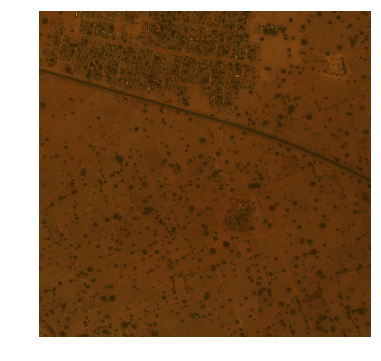

In [5]:
im = id2im(IM_ID)

plot(im)

In [6]:
h, w = im.shape[:2]

print(h, w)
print(im.min(), im.max())

3348 3403
0.0 1.0


## Create mask

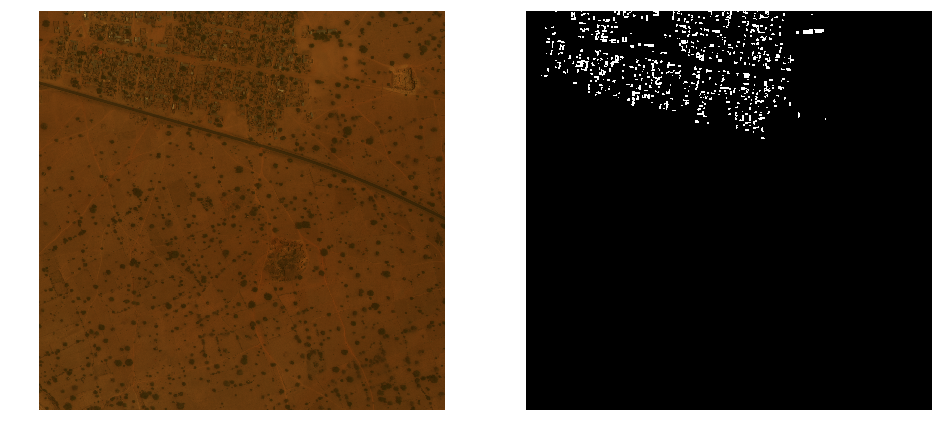

In [7]:
polygons = get_polygons(IM_ID, CLASS_ID)
mask = polygons2mask(polygons, h, w)

plot([im, mask], c=2, f=16)

## Create tiles

### Create tiles for image

In [8]:
tiles_per_col = h // TILE_LEN
tiles_per_row = w // TILE_LEN

print(tiles_per_col, tiles_per_row)

14 15


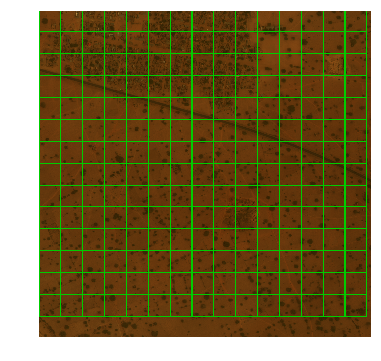

In [9]:
anchor_points = [(r*TILE_LEN, c*TILE_LEN) for r in range(tiles_per_col)
                                          for c in range(tiles_per_row)]

im2 = im.copy()
for r, c in anchor_points:
    r2, c2 = (r+TILE_LEN, c+TILE_LEN)
    cv2.rectangle(im2, (c, r), (c2, r2), GRID_COLOR, GRID_THICK)
plot(im2)

210


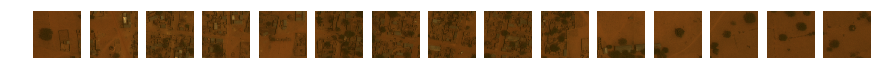

In [10]:
tiles = [im[r:r+TILE_LEN, c:c+TILE_LEN] for r, c in anchor_points]

print(len(tiles))
plot(tiles[:tiles_per_row], f=(tiles_per_row, 1), r=1, c=tiles_per_row)

### Create tiles for mask

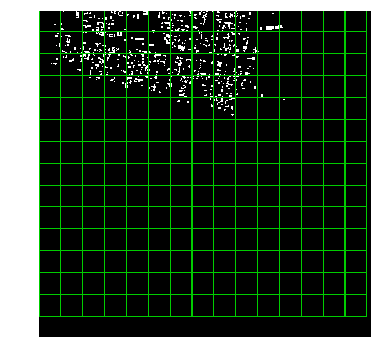

In [11]:
mask_anchor_points = [(r*TILE_LEN, c*TILE_LEN) for r in range(tiles_per_col)
                                               for c in range(tiles_per_row)]

mask2 = mask.copy()
mask2 = cv2.cvtColor(mask2, cv2.COLOR_GRAY2RGB)/255
for r, c in mask_anchor_points:
    r2, c2 = (r+TILE_LEN, c+TILE_LEN)
    cv2.rectangle(mask2, (c, r), (c2, r2), GRID_COLOR, GRID_THICK)
plot(mask2)

210


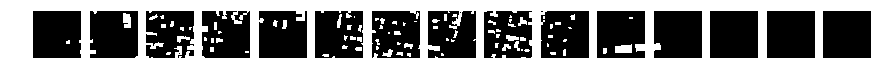

In [12]:
mask_tiles = [mask[r:r+TILE_LEN, c:c+TILE_LEN] for r, c in mask_anchor_points]

print(len(mask_tiles))
plot(mask_tiles[:tiles_per_row], f=(tiles_per_row, 1), r=1, c=tiles_per_row)

## Split tiles into train and valid

In [13]:
# Get indices
n_tiles = len(tiles)
indices = range(n_tiles)
n_val = int(n_tiles * VALID_PORTION)
indices_val = sorted(np.random.choice(indices, n_val, replace=False))
indices_trn = [i for i in indices if i not in indices_val]

assert len(indices_trn) + len(indices_val) == len(indices)
assert len(indices_val) == int(len(indices) * VALID_PORTION)

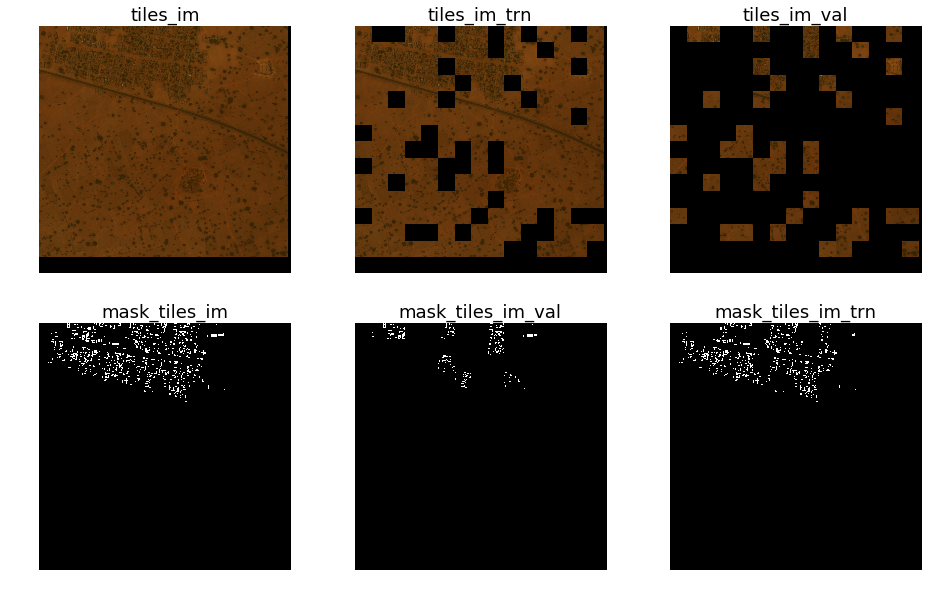

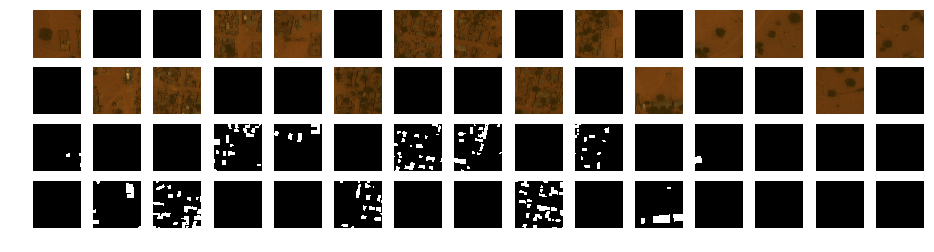

In [14]:
# Get tiles
tiles_trn = [tiles[i] for i in indices_trn]
mask_tiles_trn = [mask_tiles[i] for i in indices_trn]
tiles_val = [tiles[i] for i in indices_val]
mask_tiles_val = [mask_tiles[i] for i in indices_val]


# Print and plot to test
tiles_im = tiles2im(tiles, h, w)
tiles_with_blanks_trn = subset_tiles_with_blanks(tiles, indices_trn)
tiles_im_trn = tiles2im(tiles_with_blanks_trn, h, w)
tiles_with_blanks_val = subset_tiles_with_blanks(tiles, indices_val)
tiles_im_val = tiles2im(tiles_with_blanks_val, h, w)
mask_tiles_im = tiles2im(mask_tiles, h, w)
mask_tiles_with_blanks_trn = subset_tiles_with_blanks(mask_tiles, indices_trn)
mask_tiles_im_trn = tiles2im(mask_tiles_with_blanks_trn, h, w)
mask_tiles_with_blanks_val = subset_tiles_with_blanks(mask_tiles, indices_val)
mask_tiles_im_val = tiles2im(mask_tiles_with_blanks_val, h, w)
imgs = [tiles_im, tiles_im_trn, tiles_im_val,
        mask_tiles_im, mask_tiles_im_val, mask_tiles_im_trn]
plot(imgs, c=len(imgs)//2, r=2, f=(16, 10),
     t=['tiles_im', 'tiles_im_trn', 'tiles_im_val',
        'mask_tiles_im', 'mask_tiles_im_val', 'mask_tiles_im_trn']);plt.show()
imgs = tiles_with_blanks_trn[:tiles_per_row] + \
       tiles_with_blanks_val[:tiles_per_row] + \
       mask_tiles_with_blanks_trn[:tiles_per_row] + \
        mask_tiles_with_blanks_val[:tiles_per_row]
plot(imgs, c=tiles_per_row, r=4, f=(16, 4))

## Save

In [15]:
saveim(mask, '.png', TARGETS_BIG, IM_ID)
savetiles(tiles, '.tif', INPUTS_TILES_ALL, IM_ID)
savetiles(mask_tiles, '.png', TARGETS_TILES_ALL, IM_ID)

In [16]:
savetiles(tiles_trn, '.tif', INPUTS_TILES_TRN, IM_ID)
savetiles(mask_tiles_trn, '.png', TARGETS_TILES_TRN, IM_ID)

savetiles(tiles_val, '.tif', INPUTS_TILES_VAL, IM_ID)
savetiles(mask_tiles_val, '.png', TARGETS_TILES_VAL, IM_ID)

### Test save and load functions

dtype: [dtype('float64'), dtype('float64'), dtype('uint8'), dtype('uint8')]
shape: [(3348, 3403, 3), (224, 224, 3), (3348, 3403), (224, 224)]
mean: [0.20990581680015316, 0.22192450003688691, 5.0842683611445523, 2.5003985969387754]
std: [0.13791075171103431, 0.14482381082049067, 35.646018674232891, 25.126672065273873]
min: [0.0, 0.00821917808219178, 0, 0]
max: [1.0, 0.47945205479452052, 255, 255]
top-left pixel: [ 0.40182648  0.21552511  0.04931507]
top-left pixel: [ 0.40182648  0.21552511  0.04931507]
top-left pixel: 0
top-left pixel: 0


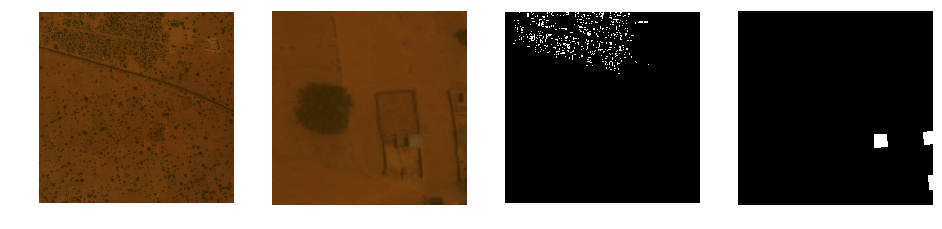

In [17]:
imgs = [loadtif(INPUTS_BIG+IM_ID+'.tif', roll=True, unit_norm=True),
        loadtif(INPUTS_TILES_ALL+IM_ID+'_000.tif'),
        loadpng(TARGETS_BIG+IM_ID+'.png'),
        loadpng(TARGETS_TILES_ALL+IM_ID+'_000.png')]
print_im_stats(imgs)

assert np.array_equal(imgs[0][0][0], imgs[1][0][0])  # Top-left pixel
assert np.array_equal(imgs[2][0][0], imgs[3][0][0])  # Top-left pixel